# Exercise 1

In this exercise we are asked to analyse the case of binary logit, when its dependent variables $y$ can take only two values: 0 or 1. In other words, the logit model the output variable $y_{i}$ is a Bernoulli random variable (it can take only two values), and:

$$
\begin{equation}
    P(y=1|x)=p(x,\theta) \label{eq1}\tag{1}
\end{equation}
$$

where

$$
\begin{equation}
    p(x,\theta)=\frac{1}{1+exp(-x'\theta)} \label{eq2}\tag{2}
\end{equation}
$$

is the logistic function, $x$ is a matrix of size $K\times n$ and $\theta$ is a $K\times1$ vector of coefficients. Likewise,

$$
\begin{equation}
    P(y=0|x)=1-p(x,\theta) \label{eq3}\tag{3}
\end{equation}
$$

The vector of coefficients $\theta$ is the parameter to be estimated by maximum likelihood in this first exercise. 

**The LIKELIHOOD**

By using the two probabilities that correspond to the two possible outcomes of our random variable, we can construct a likelihood function of the entire sample (which is equal to the product of the likelihoods of the single observations, since these are considered to be IID):

$$
\begin{equation}
    L=\prod_{i=1}^{n} \left[p(x_i,\theta)\right]^{y_i}\left[1-p(x_i,\theta)\right]^{1-y_i} \label{eq4}\tag{4}
\end{equation}
$$

We take a monotonic transformation, the logarithm of the likelihood, in order to maximize this latter instead:

$$
\begin{equation}
    \text{ln}L=\sum_{i=1}^{n} y_i\,\text{ln}\left[p(x_i,\theta)\right]+(1-y_i)\,\text{ln}\left[1-p(x_i,\theta)\right] \label{eq5}\tag{5}
\end{equation}
$$

We would like to maximize this log-likelihood function with respect to the parameters (the ones that we are trying to estimate). To this end, we will search for the values of $\hat{\theta}$ numerically. 

In [13]:
# MAIN LIBRARIES to use in Ex. 1
using Optim
using Statistics
using Plots
using DataFrames
using StatsFuns

In [9]:
# MAIN FUNCTIONS: Define the Logit Data Generating Process
function LogitDGP(n, theta)
    k = size(theta,1)
    x = ones(n,1)
    if k>1 
        x = [x  randn(n,k-1)]     # create the X matrix
    end
    y = (1.0 ./ (1.0 .+ exp.(-x*theta)) .> rand(n,1))    # compute y values given x and \theta
    return y, x
end

# Define the objective function 
function logL(theta, y, x)
    p = 1.0 ./ (1.0 .+ exp.(-x*theta))
    logdensity = y.*log.(p) .+ (1.0 .- y).*log.(1.0 .- p)
end


# Unconstrained minimization problem    
function fminunc(obj, x; tol = 1e-08)
    results = Optim.optimize(obj, x, LBFGS(), 
                            Optim.Options(
                            g_tol = tol,
                            x_tol=tol,
                            f_tol=tol))
    return results.minimizer, results.minimum, Optim.converged(results)
    #xopt, objvalue, flag = fmincon(obj, x, tol=tol)
    #return xopt, objvalue, flag
end


fminunc (generic function with 1 method)

As we have seen, $\hat{\theta}$ is an extremum estimator if $\exists\,Q_n(\theta)$ a scalar objective function such that:

$$
\begin{gather*}
    \hat{\theta}\,=\,\text{argmax}\quad Q_n(\theta) \label{eq6}\tag{6} \\
        \text{s.t.}\quad \theta\in\Theta
\end{gather*}
$$

From the two estimators that we have learned - the M-Estimator and the GMM, this exercise is devoted to the study of  one particular type of M-Estimator, the ML. The main characteristic of the M-Estimators is that they have the sample average as objective function:

$$
\begin{equation}
    Q_n=\frac{1}{n}\sum_{i=1}^{n}m(x_i;\theta) \label{eq7}\tag{7}
\end{equation}
$$

where, in the case of the ML, 

$$
\begin{equation}
    m(x_i;\theta)=\text{ln}f(x_i;\theta)\quad\rightarrow\quad Q_n=\frac{1}{n}\sum_{i=1}^{n}\text{ln}f(x_i;\theta) \label{eq8}\tag{8}
\end{equation}
$$

In summary, our job will be to focus on the following optimization problem:

$$
\begin{gather*}
    \hat{\theta}\,=\,\text{argmax} \frac{1}{n}\sum_{i=1}^{n} \left(y_i\,\text{ln}\left[p(x_i,\theta)\right]+(1-y_i)\,\text{ln}\left[1-p(x_i,\theta)\right]\right) \label{eq9}\tag{9} \\
        \text{s.t.}\quad \theta\in\Theta
\end{gather*}
$$

Numerically, we will find the minimum of the function $-Q_n(\theta)$ making use of the library Optim, the function _optimize_ , which returns, among others, the minimizer of the function. This minimization is carried out by the LBFGS method, which is an optimization algorithm in the family of quasi-Newton methods that approximates the Broyden–Fletcher–Goldfarb–Shanno algorithm (BFGS) using a limited amount of computer memory.

## (1. a) Estimate $\hat{\theta}$.

In [10]:
# Parameters
n = 1000
theta = [0.75, 0.75]

# MLE
(y,x)=LogitDGP(n, theta)                  # Generate the sample to analyse
obj = theta -> -mean(logL(theta, y, x))   # Define the objective function 
theta_trial = [1.0,0.5]                   # Define a trial value for the parameter to estimate
thetahat, junk, junk = fminunc(obj, theta_trial)
errors = abs.((theta.-thetahat)./theta)

# results
df = DataFrame(Parameters = ["Theta1", "Theta2"], True_Parameters = theta, ML_estimates=thetahat, Estimation_errors=errors)

,Parameters,True_Parameters,ML_estimates,Estimation_errors
,String,Float64,Float64,Float64
1,Theta1,0.75,0.828802,0.105069
2,Theta2,0.75,0.847985,0.130647


## (1. b) Empirically prove consistency of $\hat{\theta}$ by increasing the number of n in DGP and re-estimate.

A priori, by increasing the size of our sample for estimation in the DGP and by re-estimating, we should verify that the value of the estimates converges in probability to the true value. I added an extra variable _errors_ to see how the estimation error decreases as $n\rightarrow \infty$.

In [11]:
# New sample size (larger)
n = 10000
theta = [0.75, 0.75]

# MLE re-optimization
(y,x)=LogitDGP(n, theta)                  # Generate the sample to analyse
obj = theta -> -mean(logL(theta, y, x))   # Define the objective function 
theta_trial = [1.0,0.5]                   # Define a trial value for the parameter to estimate
thetahat, junk, junk = fminunc(obj, theta_trial)
errors = abs.((theta.-thetahat)./theta)

# results
df = DataFrame(Parameters = ["Theta1", "Theta2"], True_Parameters = theta, ML_estimates=thetahat, Estimation_errors=errors)

,Parameters,True_Parameters,ML_estimates,Estimation_errors
,String,Float64,Float64,Float64
1,Theta1,0.75,0.789098,0.0521306
2,Theta2,0.75,0.734548,0.0206026


## (1. c) Empirically prove asymptotic normality of $\hat{\theta}$ by repeatedly generating data.

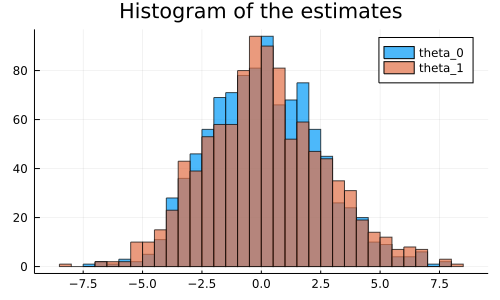

In [12]:
n = 300
theta = [0.75, 0.75]
k = size(theta,1)
reps = 1000
results = zeros(reps,k)
for i = 1:reps
    # MLE
    (y,x)=LogitDGP(n, theta)                  # Generate the sample to analyse
    obj = theta -> -mean(logL(theta, y, x))   # Define the objective function 
    theta_trial = [1.0,0.5]                   # Define a trial value for the parameter to estimate   
    thetahat, junk, junk = fminunc(obj, theta_trial)
    results[i,:] = sqrt(n)*((thetahat .- theta)')
end    
histogram(results,nbins=50,label=["theta_0" "theta_1"],title="Histogram of the estimates",alpha=0.7)
plot!(size=(500,300))

The greater the sample size, the more it will resemble to a normal distribution: we are dealing with asymptotic values, which are defined when the sample size tends to very large numbers: $n\to\infty$.